In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from torch.utils.data import DataLoader, Dataset

In [2]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 1200)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 1200))

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(1200, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc # hack to get sampling on the GPU
        self.N.scale = self.N.scale
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
class DiasTimeSeriesDataset(Dataset):
    """

       Defines the custom DIAS pytorch dataset

    """

    def __init__(self, time_series, labels: any = None, normalise: bool = True):
        self.X = time_series
        self.y = labels

        if normalise:

            self.normalise_data()

    def __len__(self):

        return len(self.X)

    def __getitem__(self, index):

        data = self.X[index, :]

        if self.y is not None:

            return (data, self.y[index])

        else:

            return (data)

    def normalise_data(self):
        
        offset = 0.5

        for idx in range(self.X.shape[0]):
            self.X[idx, :] -= self.X[idx, :].mean()
            # data /= data.std()

            max_value = np.max(np.abs(self.X[idx, :]))

            # normalise the data
            self.X[idx, :] = (self.X[idx, :] / max_value) * 0.2 + offset



In [37]:
input_dict = {"learn_data": "train_master.npy",
              "learn_labels": "labels_master.npy",
}
cut_off = 4136
# load learning and test data
learn_data = np.load(input_dict["learn_data"])
learn_labels = np.load(input_dict["learn_labels"])

# find just the good data
index_good = learn_labels == 0

learn_data = learn_data[index_good]
learn_labels = learn_labels[index_good]

# dataloaders
learn_data_ = np.reshape(

    learn_data,
    (learn_data.shape[0],
     1,
     learn_data.shape[1]
     )

 )


train_data = DiasTimeSeriesDataset(

    learn_data_[:cut_off],
    labels=learn_labels[:cut_off]

)
test_data = DiasTimeSeriesDataset(

    learn_data_[cut_off:],
    labels=learn_labels[cut_off:]

)

labels_text = ('good', 'sample', 'variable', 'em', 'contact', 'transient', 'disconnect', 'bad')

# data loaders
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100, shuffle=True)

In [5]:
def train(autoencoder, train_loader, epochs=1000):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):

            # get the inputs; data is a list of [inputs, labels]
            x, y = data
            x = x.type(torch.float32)
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
latent_dims = 5
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, train_loader)

In [7]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        x = x.type(torch.float32)
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
#         print(y)
        
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

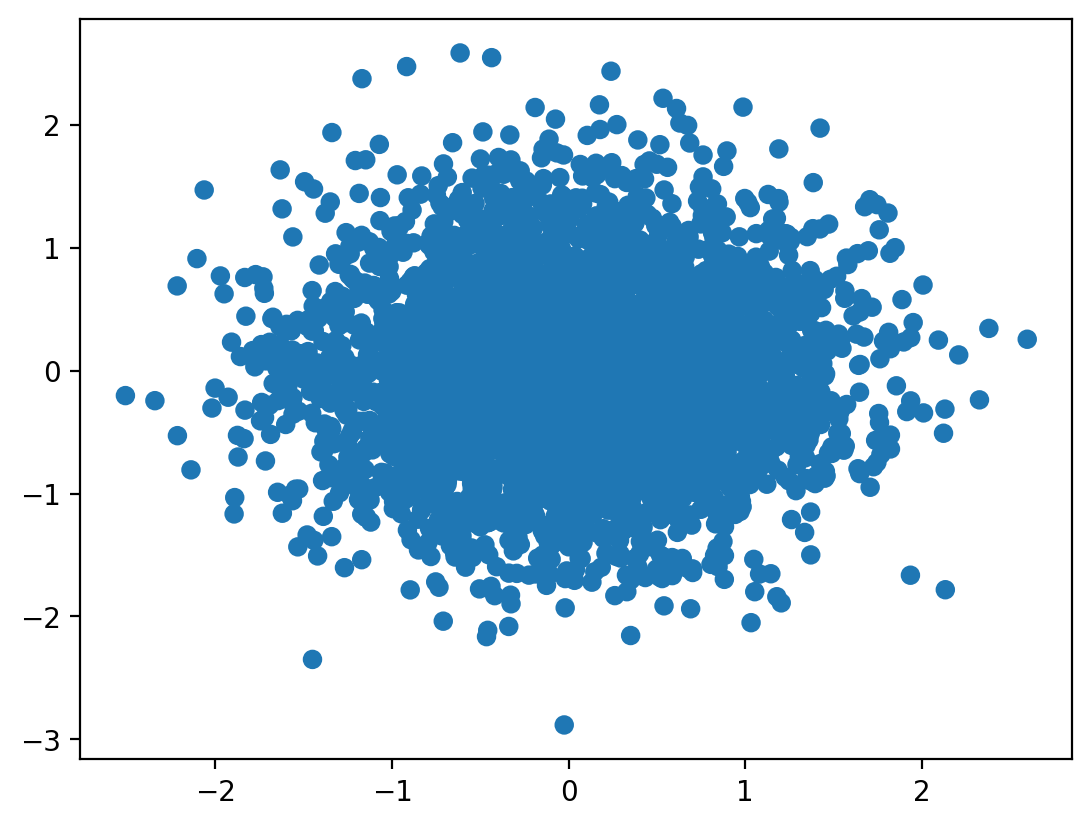

In [8]:
plot_latent(vae, train_loader)

In [50]:
# type(test_data[0][0])
xc = torch.from_numpy(test_data[100][0]).type(torch.float32)
print(vae(xc).view(1, 1200))

# save the model to disk
# torch.save(vae, 'vae-ts')

tensor([[0.5148, 0.5530, 0.6107,  ..., 0.4993, 0.4992, 0.5020]],
       grad_fn=<ViewBackward0>)


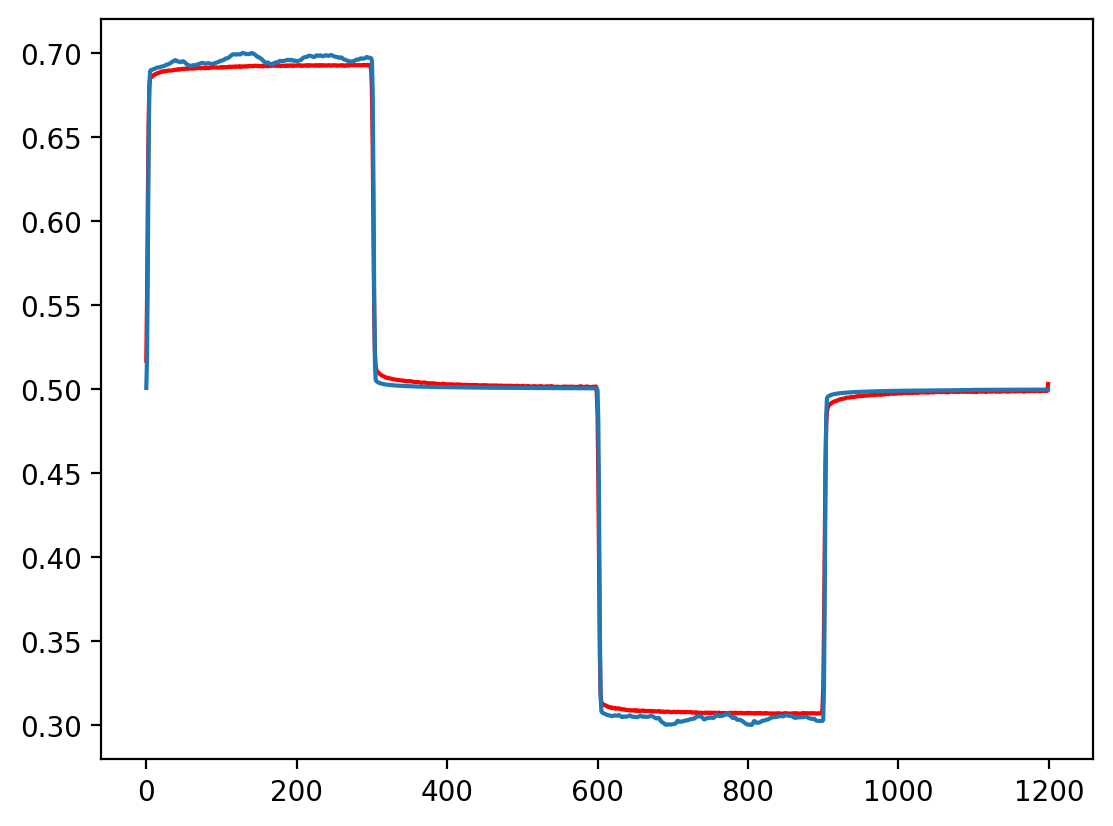

In [39]:
xc.detach().numpy().shape
plt.plot(vae(xc).view(1, 1200).detach().numpy()[0,:], 'r')
plt.plot(xc.detach().numpy()[0,:])
plt.show()

In [13]:
np.linalg.norm(vae(xc).view(1, 1200).detach().numpy()[0,:] - xc.detach().numpy()[0,:])

0.13761011

In [96]:

# try with other data
learn_data_ = np.load(input_dict["learn_data"])
learn_labels_ = np.load(input_dict["learn_labels"])

# find just the good data
index_test = learn_labels_ == 0

learn_data = learn_data_[index_test]
learn_labels = learn_labels_[index_test]
print(index_test.sum())

# dataloaders
learn_data_ = np.reshape(

    learn_data,
    (learn_data.shape[0],
     1,
     learn_data.shape[1]
     )

 )


_test_data = DiasTimeSeriesDataset(

    learn_data_,
    labels=learn_labels

)

5136


<IPython.core.display.Javascript object>


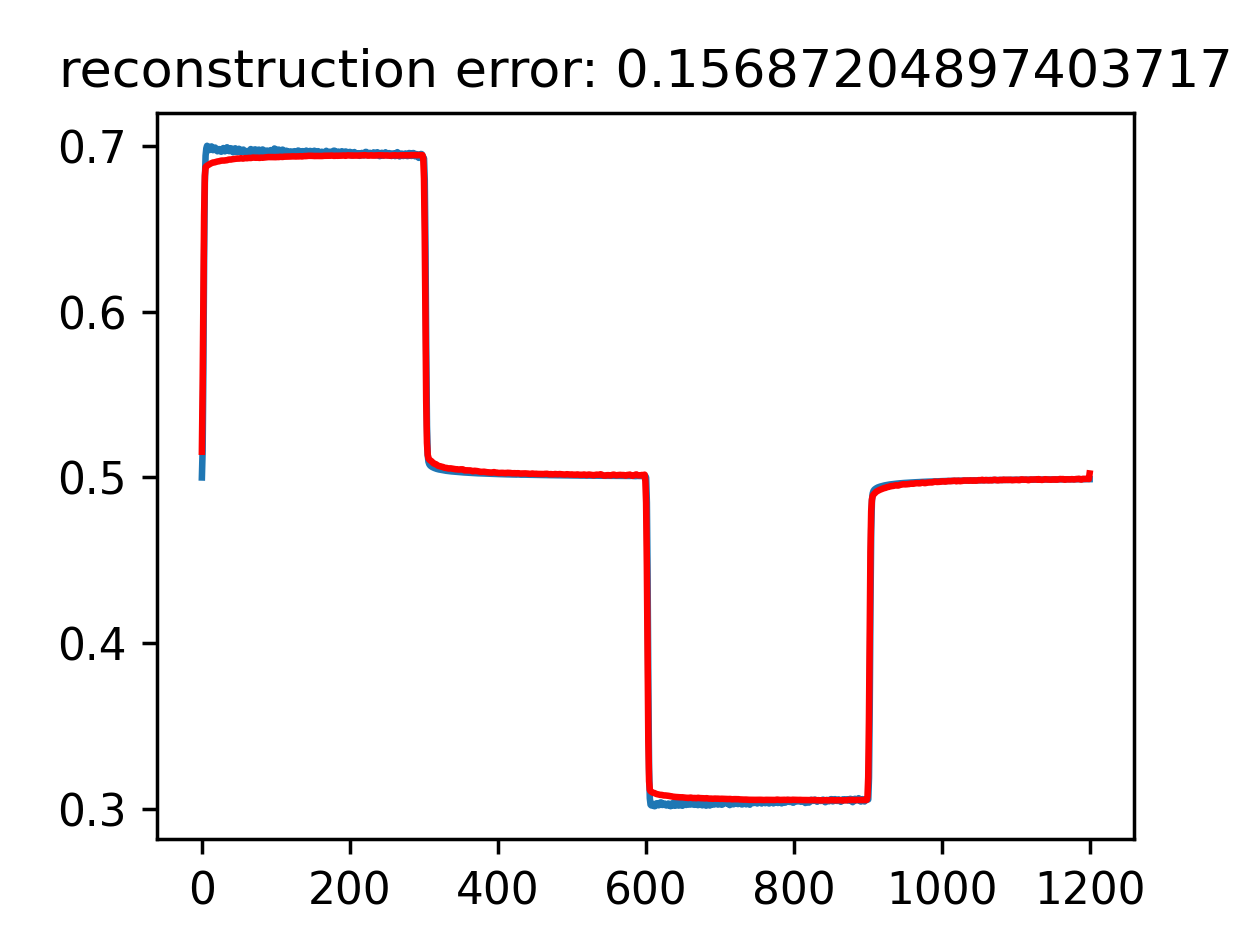

In [103]:
# %matplotlib notebook
xc = torch.from_numpy(_test_data[80][0]).type(torch.float32)
# print(vae(xc).view(1, 1200))
# print(vae(xc).view(1, 1200).detach().numpy()[0, :])
plt.figure(figsize=(4,3))
plt.plot(xc.detach().numpy()[0,:])
plt.plot(vae(xc).view(1, 1200).detach().numpy()[0, :], 'r')
plt.title(f"reconstruction error: {np.linalg.norm(vae(xc).view(1, 1200).detach().numpy()[0,:] - xc.detach().numpy()[0,:])}")
plt.show()